<font size=10>Laboratory Assignment 3.1</font>

# Introduction
In this laboratory, we will cover the basic element of programming using a map-reduce methodology. For that purpose, we will be using Apache Spark as a reference, but bear in mind that similar frameworks exists and principles can be extrapolated.

## Some concepts and facts

- Spark is a distributed computing platform that operates on a cluster. Like MPI, we expect that nodes does NOT share a memory space but they are connected in high-speed dedicated network. Distributed filesystems that work over the network are extremely useful.

- It is considered the next generation of previous map-reduce standard Apache Hadoop. Main difference is thought to be the use of the memory instead of disk for intermediate operations, but there are many more improvements.

- It is built on Java. Despite this, it can be programmed using Java, Scala, Python or R. The complete API can only be found in JVM-based languages but the most frequent one is PySpark, since people is reluctant to use JVM-based languages in data science. Indeed, since Hadoop was only available for Java, it is likely that some Java codes of Spark are adaptations of previous Hadoop codes.

- Resilient Distributed Dataset (RDD): the basic unit that is processed in Spark. Equivalent to a numpy array but distributed.

- RDD API usually exposes the low-level operations of Apache Spark, useful for preprocessing data but useless for data analytics

- For data analysis, Dataframe and Spark SQL is used. It relies on a pandas-alike API that even accepts SQL code (which may sound crazy and useless for developers, but many *old* data scientists and statisticians are really proficient in SQL but not in Python).

## How to install Spark in colab.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install JVM v8
!wget -q https://downloads.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz # Download latest release. Update if necessary
!tar xf spark-3.3.1-bin-hadoop3.tgz # Unzip
!pip install pyspark # Well, the library itself
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 55.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=b620dc37f443ae2bbb0e9a2ada1f6dcd70d066dc663e25302e9a9a4d3aa8222f
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


## How to initialize Spark

In [ ]:
from pyspark.sql import SparkSession

APP_NAME = "CAP-lab3"
SPARK_URL = "local[*]"
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sc = spark.sparkContext

# First Part: RDDs

## Basic operations

### Parallelize & collect

It creates a RDD out of a list or array. Second argument indicates the number of pieces of the RDD

In [ ]:
array = sc.parallelize([1,2,3,4,5,6,7,8,9,10], 2)
array

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274

In [ ]:
import numpy as np
randomSamples = sc.parallelize(np.random.randn(100))
randomSamples

ParallelCollectionRDD[1] at readRDDFromFile at PythonRDD.scala:274

Cool, RDDs can not be printed...

Of course, RDDs can not be printed unless they are reduced

In [ ]:
print(array.collect())
print(randomSamples.collect())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[-0.346121841982338, 1.3605474241922249, -0.9280895716549198, -0.5777185382528427, -0.23159237826678525, -0.5295021340159698, -1.333892993118826, 2.3247083234095163, -1.0229411379175066, -1.5212429184572651, -0.9623993934083703, 1.2106506473188408, -1.1052319648167996, 1.0632536468349545, 0.6863574797687839, 0.15882054963387052, 0.6586385324137153, 1.8986903241830315, 0.06702561228627703, 1.1541747230522132, -0.2252284347399707, -0.06717016056226123, -0.6472936997597912, -0.5796639870833716, -0.3767979343506733, -0.9630668810167903, 0.5080647228051977, -0.5437347975231916, 1.1709641576895213, -0.4344114219959199, 0.29375288250231046, -1.8559661721893002, 2.005541694914905, 0.5731198426014026, 0.5015408877175496, 0.7895080292158051, -1.5766499330797692, -0.20725128772561932, 1.2321052523895788, 0.5821778048054774, 0.5936808761996497, -0.9225320469633236, -0.8514065525502137, -0.810289689195179, 1.5084710303057818, -1.7964149053424174, 2.5150873629484214, 

Spark uses lazy operations for everything, this means that nothing is evaluated until an action, a reduce operation normally, is performed. The basic reduce operation is collect, which returns the whole RDD (i.e. no reduction is performed).

### Other ways of loading data

In [ ]:
import requests

request = requests.get("https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt")
with open("elquijote.txt", "wb") as f:
  f.write(request.content) 

In [ ]:
quijote = sc.textFile("elquijote.txt")
quijote.take(10)

Here, you can see both a method to load a text file line per line and a another reduction operation.

In [ ]:
quijote.take?

### Transformations

Let's review all the transformation that can be performed to data.

In [ ]:
charsPerLine = quijote.map(lambda s: len(s))
allWords = quijote.flatMap(lambda s: s.split())
allWordsNoArticles = allWords.filter(lambda a: a.lower() not in ["el", "la"])
allWordsUnique = allWords.map(lambda s: s.lower()).distinct()
sampleWords = allWords.sample(withReplacement=True, fraction=0.2, seed=666)
weirdSampling = sampleWords.union(allWordsNoArticles.sample(False, fraction=0.3))

In [ ]:
allWordsUnique.take(10)

--------


<font size=10 color=red>Assignment question</font>
--------

Explain the use and purpose of each operation above.
--------
Comment also on the size of the resulting RDD in terms of the size of the original RDD, e.g. if original RDD is of size $N$, then rdd.filter() is of size $K\leq N$
--------
--------
Answer:

Assuming the original RDD is of size $N$,

- **map**: Applies a function to each element of the RDD and returns a new RDD. (RDD size = $N$)
- **flatMap**: Applies a function to each element of the RDD, flattens the results and returns a new RDD. (RDD size = undetermined size between 0 and infinite, as the flatten property could return any value)
- **filter**: Returns a new RDD containing only the elements that satisfy a predicate. (RDD size = $K\leq N$)
- **distinct**: Returns an RDD with all the unique elements from the RDD. (RDD size = $K\leq N$)
- **sample**: Samples a fraction of data randomly with or without replacement. (RDD size = $N* fraction$)
- **union**: Returns a new RDD with the two imput RDDS concatenated. (RDD size = $N1 + N2$)

----

 ### Actions

 

In [ ]:
numLines = quijote.count()
numChars = charsPerLine.reduce(lambda a,b: a+b) # also charsPerLine.sum()
sortedWordsByLength = allWordsNoArticles.takeOrdered(10, key=lambda x: -len(x))
numLines, numChars, sortedWordsByLength

(2186,
 1036211,
 ['procuremos.Levántate,',
  'extraordinariamente,',
  'estrechísimamente,',
  'convirtiéndoseles',
  'entretenimientos,',
  'inadvertidamente.',
  'cortesísimamente',
  'Agredeciéronselo',
  'Pintiquiniestra,',
  'entretenimiento,'])

--------


<font size=10 color=red>Assignment question</font>

Explain the use and purpose of each action above.

Implement the count operation using reduce as the unique option. You can use transformations. Is it possible to achieve a solution without any transformation? Does it make sense?

--------
Answer:
 - **count**: Counts all the elements inside the RDD.
 - **reduce**: Reduces elements of the RDD applying a binary operator.
 - **sum**: Sums all the values inside the RDD.
 - **takeOrdered**: Selects the first N given elements in ascending order. It is also possible to modify the key by which the sorting will be alpplied.


**Implement count using only reduce and transformations**
In order to implement count only with reduce and transformations, we should do as it follows:

```
transQuijote = quijote.map(lambda a: 1)
numLinesReduce = transQuijote.reduce(lambda a,b: a+b)
```

In this lines we perform a map operation on the quijote that asigns a value of 1 to each line and after that we execute the reduce that sums the value of each line adding then to the total amount of lines.

It is impossible to perform this operation without transformations because an action is performed over a previous transformation (which makes sense because the technology is called Map-Reduce). 


----

## Key-Value RDDs

In [ ]:
import re
allWords = allWords.flatMap(lambda w: re.sub(""";|:|\.|,|-|–|"|'|\s"""," ", w.lower()).split(" ")).filter(lambda a: len(a)>0)
allWords2 = sc.parallelize(requests.get("https://gist.githubusercontent.com/jsdario/9d871ed773c81bf217f57d1db2d2503f/raw/585de69b0631c805dabc6280506717943b82ba4a/el_quijote_ii.txt").iter_lines())
allWords2 = allWords2.flatMap(lambda w: re.sub(""";|:|\.|,|-|–|"|'|\s"""," ", w.decode("utf8").lower()).split(" ")).filter(lambda a: len(a)>0)

In [ ]:
allWords.take(10), allWords2.take(10)

Next, we move to more interesting operations that involve key-value RDDs. Key-value RDDs are a special kind of RDDs where each is element is a tuple (K,V) where K is the key and V the value.

In [ ]:
words = allWords.map(lambda e: (e,1))
words2 = allWords2.map(lambda e: (e,1))

words.take(10)

### How to manipulate K-V RDDs

In [ ]:
frequencies = words.reduceByKey(lambda a,b: a+b)
frequencies2 = words2.reduceByKey(lambda a,b: a+b)
frequencies.takeOrdered(10, key=lambda a: -a[1])

In [ ]:
res = words.groupByKey().takeOrdered(10, key=lambda a: -len(a))
res # To see the content, res[i][1].data

In [ ]:
joinFreq = frequencies.join(frequencies2)
joinFreq.take(10)

In [ ]:
joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: -v[1]), joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: +v[1])

In [ ]:
words = allWords.map(lambda e: (e,1))
res = words.groupByKey().mapValues(len)
res.take(10)

--------


<font size=10 color=red>Assignment question</font>
--------
Explain the use and purpose of each action above.
--------

Answer:

- **reducedByKey**: Transformation that merges the values of each key  using an associative reduce function. (`map.reducedByKey(lambda expression on how to merge)`)
- **groupedByKey**: Group the values for each key in the RDD into a single sequence. (`map.groupedByKey()`)
- **join**: Performs an Inner Join operation on two maps. (`map1.join(map2)`)


--------
Implement the frequency with groupByKey and transformations.
--------

Answer:

First we map all the words and assign a value of 1 (arbitrary) to each one of them so they all have a key and a value, then we group by key and get the amount of elements that have been grouped (which is the frecuency) into the value of each different key.
```
words = allWords.map(lambda e: (e,1))
res = words.groupByKey().mapValues(len)
```



--------
Which of the two following cells is more efficient?
--------


Answer:

Both cells are **equally efficient** because unlike Hadoop, intermediate RDDs are nor preserved and each time we use an action the **complete pipeline is executed**.

------

In [ ]:
joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: -v[1]), joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: +v[1])

In [ ]:
result = joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1])))
result.takeOrdered(10, lambda v: -v[1]), result.takeOrdered(10, lambda v: +v[1])

## Optimizations and final notes

### Optimizing the data movement around the cluster

One of the main issues could be that if data after an operation is not balanced, we may not be using the cluster properly. For that purpose, we have two operations


In [ ]:
result.coalesce(numPartitions=200) # Avoids the data movement, so it tries to balance inside each machine
result.repartition(numPartitions=200) # We don't care about data movement, this balance the whole thing to ensure all machines are used

MapPartitionsRDD[55] at coalesce at NativeMethodAccessorImpl.java:0

### Persistance for intermediate operations
In contrast to Hadoop, intermediate RDDs are not preserved, each time we use an action/reduction, the whole data pipeline is executed from the datasources. To avoid this:


In [ ]:
result.take(10)
allWords.cache() # allWords RDD must  stay in memory after computation, we made a checkpoint (well, it's a best effort, so must might be too strong)
result.take(10)

[('don', -0.19940253920836445),
 ('mancha', -0.33774834437086093),
 ('saavedra', 0.3333333333333333),
 ('primera', -0.1702127659574468),
 ('parte', 0.05952380952380952),
 ('1', 0.0),
 ('que', 0.03205591708845505),
 ('condición', -0.08333333333333333),
 ('y', -0.05360847254067038),
 ('del', -0.08737864077669903)]

In [ ]:
from pyspark import StorageLevel
# https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html#rdd-persistence
allWords2.persist(StorageLevel.MEMORY_AND_DISK) # Now it will be preserved on disk also

PythonRDD[59] at RDD at PythonRDD.scala:53

In [ ]:
!rm -rf palabras_parte2
allWords3 = allWords2.repartition(numPartitions=20)
allWords3.saveAsTextFile("palabras_parte2")

In [ ]:
!ls palabras_parte2

part-00000  part-00004	part-00008  part-00012	part-00016  _SUCCESS
part-00001  part-00005	part-00009  part-00013	part-00017
part-00002  part-00006	part-00010  part-00014	part-00018
part-00003  part-00007	part-00011  part-00015	part-00019


--------


<font size=10 color=red>Assignment question</font>
--------
Before saving with saveAsTextFile, use coalesce with different values. What's the difference in the previous ls? 
--------

--------
Answer:

The difference is the **amount of part-xxxxx files** it generates which is equal to the numPartitions argument in the coalesce. This is because one of these files is generated for each partition the parallelization makes, and with the coalesce instruction we are only able to **reduce** the amount of **partitions** not increase it. In order to increase the number of partitions we would have to use repartition. 

----

### Global variables

There are two kind of global variables, read-only and write-only.

In [ ]:
articles = sc.broadcast(["el", "la"])
articles.value

['el', 'la']

Broadcast variables are read-only. They help us to avoid local variables of the closures (the functions we use inside map, reduce, ...) to be transferred in every single Spark operation. In that way, they are only transferred only once.

In [ ]:
acc = sc.accumulator(0)
def incrementar(x):
  global acc
  acc += x

allWords.map(lambda l:1).foreach(incrementar)
acc

Accumulator<id=0, value=187045>

Write-only variables can be also declared and initialized, but they can not be read since reading will force a complete synchronization of the cluster.

# Second part: Spark SQL

Next, we will do a short review of the high-level API of Spark

In [ ]:
import pandas as pd

size = int(1e6)
def loadRedditToPandas(subreddit=None, size=size):
  if subreddit is not None:
    redditData = requests.get(f"https://api.pushshift.io/reddit/search/submission/?subreddit={subreddit}&sort=desc&sort_type=created_utc&size={size:d}").json()
  else:
    redditData = requests.get(f"https://api.pushshift.io/reddit/search/submission/?sort=desc&sort_type=created_utc&size={size:d}").json()
  return pd.DataFrame(redditData["data"])

In [ ]:
pdf = loadRedditToPandas("askspain")
pdf.head(10)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,thumbnail_height,thumbnail_width,url_overridden_by_dest,is_gallery,poll_data,author_cakeday,media,media_embed,secure_media,secure_media_embed
0,[],False,Thadar_Oficial,None,[],None,text,t2_9wunlu0d,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,Difficult_Ad6093,None,[],None,text,t2_8upq7bbm,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,allhailthehale,None,[],None,text,t2_j509e,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,CulturalStill1210,None,[],None,text,t2_moep8bp6,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,KamiMaziKazu,None,[],None,text,t2_j1m5d2c6,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,[],False,Ok-Strategy-7923,None,[],None,text,t2_tu1mn5jv,False,False,...,105.0,140.0,https://youtube.com/shorts/l8e5O84HwmM?feature...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,[],False,CulturalStill1210,None,[],None,text,t2_moep8bp6,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,[],False,CulturalStill1210,None,[],None,text,t2_moep8bp6,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,[],False,LemonJuice96,None,[],None,text,t2_zey0s,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,[],False,InformationLess4182,None,[],None,text,t2_754h0jgm,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pdf.selftext = pdf.selftext.apply(lambda e: str(e))

In [ ]:
attrs = ["author", "created_utc", "title", "subreddit", "selftext", "over_18", ]
df = spark.createDataFrame(pdf[attrs])

## Basic operations

In [ ]:
df.show()

+-------------------+-----------+--------------------+---------+--------------------+-------+
|             author|created_utc|               title|subreddit|            selftext|over_18|
+-------------------+-----------+--------------------+---------+--------------------+-------+
|     Thadar_Oficial| 1670168459|    Me voy a Twitch?| askspain|           [removed]|  false|
|   Difficult_Ad6093| 1670166512|Por favor eviten ...| askspain|La primera noche ...|  false|
|     allhailthehale| 1670166235|Día de la Toma de...| askspain|Hola chicos,\n\nW...|  false|
|  CulturalStill1210| 1670166184|¿Que sabéis acerc...| askspain|Estoy interesado ...|  false|
|       KamiMaziKazu| 1670163146|Invitación a foro...| askspain|                    |  false|
|   Ok-Strategy-7923| 1670162234|Liver King doesn’...| askspain|                    |  false|
|  CulturalStill1210| 1670161955|QUIERO VIVIR EN U...| askspain|[removed]\n\n[Vie...|  false|
|  CulturalStill1210| 1670159358|Debate acerca de ...| asksp

### Filtering

In [ ]:
df.filter(~df.over_18).show()

+-------------------+-----------+--------------------+---------+--------------------+-------+
|             author|created_utc|               title|subreddit|            selftext|over_18|
+-------------------+-----------+--------------------+---------+--------------------+-------+
|     Thadar_Oficial| 1670168459|    Me voy a Twitch?| askspain|           [removed]|  false|
|   Difficult_Ad6093| 1670166512|Por favor eviten ...| askspain|La primera noche ...|  false|
|     allhailthehale| 1670166235|Día de la Toma de...| askspain|Hola chicos,\n\nW...|  false|
|  CulturalStill1210| 1670166184|¿Que sabéis acerc...| askspain|Estoy interesado ...|  false|
|       KamiMaziKazu| 1670163146|Invitación a foro...| askspain|                    |  false|
|   Ok-Strategy-7923| 1670162234|Liver King doesn’...| askspain|                    |  false|
|  CulturalStill1210| 1670161955|QUIERO VIVIR EN U...| askspain|[removed]\n\n[Vie...|  false|
|  CulturalStill1210| 1670159358|Debate acerca de ...| asksp

In [ ]:
df.where(~df.over_18).show()

+-------------------+-----------+--------------------+---------+--------------------+-------+
|             author|created_utc|               title|subreddit|            selftext|over_18|
+-------------------+-----------+--------------------+---------+--------------------+-------+
|     Thadar_Oficial| 1670168459|    Me voy a Twitch?| askspain|           [removed]|  false|
|   Difficult_Ad6093| 1670166512|Por favor eviten ...| askspain|La primera noche ...|  false|
|     allhailthehale| 1670166235|Día de la Toma de...| askspain|Hola chicos,\n\nW...|  false|
|  CulturalStill1210| 1670166184|¿Que sabéis acerc...| askspain|Estoy interesado ...|  false|
|       KamiMaziKazu| 1670163146|Invitación a foro...| askspain|                    |  false|
|   Ok-Strategy-7923| 1670162234|Liver King doesn’...| askspain|                    |  false|
|  CulturalStill1210| 1670161955|QUIERO VIVIR EN U...| askspain|[removed]\n\n[Vie...|  false|
|  CulturalStill1210| 1670159358|Debate acerca de ...| asksp

In [ ]:
df.where("not over_18").show() # SQL syntax

+-------------------+-----------+--------------------+---------+--------------------+-------+
|             author|created_utc|               title|subreddit|            selftext|over_18|
+-------------------+-----------+--------------------+---------+--------------------+-------+
|     Thadar_Oficial| 1670168459|    Me voy a Twitch?| askspain|           [removed]|  false|
|   Difficult_Ad6093| 1670166512|Por favor eviten ...| askspain|La primera noche ...|  false|
|     allhailthehale| 1670166235|Día de la Toma de...| askspain|Hola chicos,\n\nW...|  false|
|  CulturalStill1210| 1670166184|¿Que sabéis acerc...| askspain|Estoy interesado ...|  false|
|       KamiMaziKazu| 1670163146|Invitación a foro...| askspain|                    |  false|
|   Ok-Strategy-7923| 1670162234|Liver King doesn’...| askspain|                    |  false|
|  CulturalStill1210| 1670161955|QUIERO VIVIR EN U...| askspain|[removed]\n\n[Vie...|  false|
|  CulturalStill1210| 1670159358|Debate acerca de ...| asksp

### Operations



In [ ]:
df.select(df.created_utc * 2).show()

+-----------------+
|(created_utc * 2)|
+-----------------+
|       3340336918|
|       3340333024|
|       3340332470|
|       3340332368|
|       3340326292|
|       3340324468|
|       3340323910|
|       3340318716|
|       3340316724|
|       3340312246|
|       3340310956|
|       3340310468|
|       3340309128|
|       3340308158|
|       3340304860|
|       3340304734|
|       3340304564|
|       3340304234|
|       3340303556|
|       3340303252|
+-----------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import log
df.select(log(df.created_utc * 2)).show()

+---------------------+
|ln((created_utc * 2))|
+---------------------+
|    21.92933751250031|
|    21.92933634674896|
|    21.92933618089722|
|   21.929336150361337|
|   21.929334331379014|
|   21.929333785324427|
|    21.92933361827477|
|    21.92933206333454|
|   21.929331466984085|
|   21.929330126391747|
|    21.92932974020023|
|   21.929329594106036|
|    21.92932919294564|
|   21.929328902553316|
|    21.92932791521877|
|   21.929327877497663|
|     21.9293278266041|
|    21.92932772781071|
|   21.929327524835166|
|    21.92932743382547|
+---------------------+
only showing top 20 rows



### Aggregations



In [ ]:
df.where("not over_18").groupby(["author", df.subreddit]).count().toPandas()

,author,subreddit,count
0,WilmitaFany,askspain,2
1,cabrogang,askspain,1
2,fakerht,askspain,1
3,Business_Frog34,askspain,1
4,duaibs,askspain,1
...,...,...,...
198,Orion_2824,askspain,1
199,officiallights,askspain,1
200,MaereighLeigh,askspain,1
201,superxjoseito,askspain,1


### Custom functions

In [ ]:
from pyspark.sql.functions import length

df = df.withColumn("length", length(df.selftext)) # This adds a column

df.where("length > 100").toPandas()

,author,created_utc,title,subreddit,selftext,over_18,length
0,Difficult_Ad6093,1670166512,Por favor eviten ir a Effetá. ES UNA SECTA.,askspain,"La primera noche te drogan, te quitan cualquie...",False,572
1,allhailthehale,1670166235,Día de la Toma de Granada-- tell me more,askspain,"Hola chicos,\n\nWe're going to be in Southern ...",False,700
2,CulturalStill1210,1670166184,¿Que sabéis acerca de manipulación de masas?,askspain,"Estoy interesado en teoría de la publicidad, p...",False,176
3,CulturalStill1210,1670159358,Debate acerca de Dios,askspain,Estoy dispuesto a un enfrentamiento retórico c...,False,324
4,LemonJuice96,1670158362,Mejor seguro de salud?,askspain,Muy buenas a todos. \n\nPues la pregunta viene...,False,654
...,...,...,...,...,...,...,...
153,officiallights,1669471462,¿Qué pasa con España y el sueldo?,askspain,"Buenas a todos, recientemente he conseguido mi...",False,625
154,stpeppa,1669462780,saffron in spain?,askspain,hey all! i'm visiting spain with family and my...,False,349
155,Ok_Doubt7482,1669453681,Ciudadania Española,askspain,"Buenas, quiero saber si puedo sacar la ciudada...",False,336
156,LFL0,1669430797,Historical Basque Anti-semitism? Could not bec...,askspain,Someone was saying back 500+ years ago in the ...,False,431


In [ ]:
from pyspark.sql.functions import udf

def splitWords(e):
  return e.split(" ")
  
splitWords = udf(splitWords)
df.select(splitWords(df.selftext)).show()

+--------------------+
|splitWords(selftext)|
+--------------------+
|         [[removed]]|
|[La, primera, noc...|
|[Hola, chicos,\n\...|
|[Estoy, interesad...|
|                  []|
|                  []|
|[[removed]\n\n[Vi...|
|[Estoy, dispuesto...|
|[Muy, buenas, a, ...|
|[I, work, for, a,...|
|                  []|
|                  []|
|[En, mi, antiguo,...|
|[Buenas,, os, pon...|
|         [[removed]]|
|         [[removed]]|
|         [[removed]]|
|         [[removed]]|
|         [[removed]]|
|         [[removed]]|
+--------------------+
only showing top 20 rows



In [ ]:

df = spark.createDataFrame(pdf[attrs])


df.groupby(["author"]).count().filter("`count` >= 2").toPandas()

,author,count
0,wolsid,8
1,Revolutionary-Elk430,2
2,opsmuk,2
3,tapzfamily,3
4,thugga511,2
5,blasila,2
6,WilmitaFany,2
7,Powerful-Employer-20,2
8,WinterCharacter21,2
9,CulturalStill1210,3


--------
<font size=10 color=red>Assignment question</font>
--------
Obtain the users who have posted in reddit more than 1k posts in any subreddit
--------


--------
Answer:

The code only gets a limited amount of posts sorted by the posting time, so we do not have all the data to know how many posts each user has posted from the moment their account was set up. However, if we had all the data, the code to obtain all the users that have posted more than 1K posts on any subreddit would be the following:

`df.groupby(["author"]).count().filter("'count' >= 2").toPandas()`

Or maybe when the pushshift api finishes the development of the user analysis feature, we would be able to use it to obtain the amount of posts of each user directly.

-----

## SQL operations

### How to declare a view from a Dataframe

In [ ]:
df.createOrReplaceTempView("reddit")

In [ ]:
spark.sql("select * from reddit limit 10").show()

+-------------------+-----------+--------------------+---------+--------------------+-------+
|             author|created_utc|               title|subreddit|            selftext|over_18|
+-------------------+-----------+--------------------+---------+--------------------+-------+
|     Thadar_Oficial| 1670168459|    Me voy a Twitch?| askspain|           [removed]|  false|
|   Difficult_Ad6093| 1670166512|Por favor eviten ...| askspain|La primera noche ...|  false|
|     allhailthehale| 1670166235|Día de la Toma de...| askspain|Hola chicos,\n\nW...|  false|
|  CulturalStill1210| 1670166184|¿Que sabéis acerc...| askspain|Estoy interesado ...|  false|
|       KamiMaziKazu| 1670163146|Invitación a foro...| askspain|                    |  false|
|   Ok-Strategy-7923| 1670162234|Liver King doesn’...| askspain|                    |  false|
|  CulturalStill1210| 1670161955|QUIERO VIVIR EN U...| askspain|[removed]\n\n[Vie...|  false|
|  CulturalStill1210| 1670159358|Debate acerca de ...| asksp

In [ ]:
spark.sql("select author, sum(length(selftext)) as chars from reddit group by author having chars>1000 ").show()

+--------------------+-----+
|              author|chars|
+--------------------+-----+
|Revolutionary-Elk430| 1728|
|              opsmuk| 1384|
|        navidshrimpo| 1073|
|     Plus-Budget8771| 1586|
|  Intrepid_Earth8013| 1954|
|Powerful-Employer-20| 1420|
|          ChristFita| 4698|
|       madalina_1997| 1098|
|        letdekusmash| 1651|
| SufficientAdagio914| 3252|
|             Eich_md| 3625|
|            Noestoyy| 1223|
|TaroEnvironmental627| 1100|
|         D3ltaV1ctor| 1625|
|    LatighinoCarmona| 2344|
|      aricharliegold| 1422|
|          l1mitl3ss_| 1122|
|   Sure-WrapsAreFine| 1020|
|          ericvonass| 1100|
|      MischievousFFF| 2379|
+--------------------+-----+
only showing top 20 rows



--------


<font size=10 color=red>Assignment question</font>

Obtain the users who have posted in reddit more than 1k characters in any subreddit with SQL (without using any column named length)

--------
Answer:

```
spark.sql("select author, sum(length(selftext)) as chars from reddit group by author having chars>1000 ").show()
```

This queries all the authors that have at least a post with more than 1K characters. First we get all the authors and their posts lengths, we group by author and add the lengths and finally we filter to only those that have posted more than 1000 characters.

----

## Other libraries

Beyond dataframes, we can find other libraries that also rely on Spark...

In [ ]:
!pip install koalas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 390 kB 5.1 MB/s 


In [ ]:
import databricks.koalas as ks
import pandas as pd

# Create a Koalas DataFrame from pandas DataFrame
kdf = ks.from_pandas(pdf[attrs])

kdf.head()

,author,created_utc,title,subreddit,selftext,over_18
0,Thadar_Oficial,1670168459,Me voy a Twitch?,askspain,[removed],False
1,Difficult_Ad6093,1670166512,Por favor eviten ir a Effetá. ES UNA SECTA.,askspain,"La primera noche te drogan, te quitan cualquie...",False
2,allhailthehale,1670166235,Día de la Toma de Granada-- tell me more,askspain,"Hola chicos,\n\nWe're going to be in Southern ...",False
3,CulturalStill1210,1670166184,¿Que sabéis acerca de manipulación de masas?,askspain,"Estoy interesado en teoría de la publicidad, p...",False
4,KamiMaziKazu,1670163146,"Invitación a forocoches, alguien?",askspain,,False


In [ ]:
kdf["sumChars"] = kdf.selftext.str.len()
res = kdf.groupby(["author", "subreddit"]).sum()
res[res.sumChars > 1000]

,,created_utc,sumChars
author,subreddit,,
Plus-Budget8771,askspain,1670026100,1586
madalina_1997,askspain,1670007794,1098
letdekusmash,askspain,1669846739,1651
Revolutionary-Elk430,askspain,3339608301,1728
ChristFita,askspain,8349398439,4698
Powerful-Employer-20,askspain,3339799184,1420
opsmuk,askspain,3339745962,1384
SufficientAdagio914,askspain,10018164457,3252
navidshrimpo,askspain,1669910599,1073


Text(0, 0.5, 'Frequency')

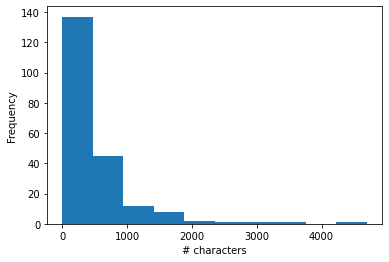

In [ ]:
import matplotlib.pyplot as plt
plt.hist(res.sumChars.to_numpy())
plt.xlabel("# characters")
plt.ylabel("Frequency")
#plt.xscale("log")

In [ ]:
!curl https://2.bp.blogspot.com/-eGskF3n8_Ag/XE7F3P_de2I/AAAAAAAAHU8/WJw0un2nHqMGA8cFVtv_yFfpBVQJSYyVACK4BGAYYCw/s1600/Icon-Reddit.png > reddit.png
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

mask = np.array(Image.open("reddit.png"))
text = " ".join([i for i in kdf.author.to_numpy()])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 76154  100 76154    0     0   688k      0 --:--:-- --:--:-- --:--:--  688k


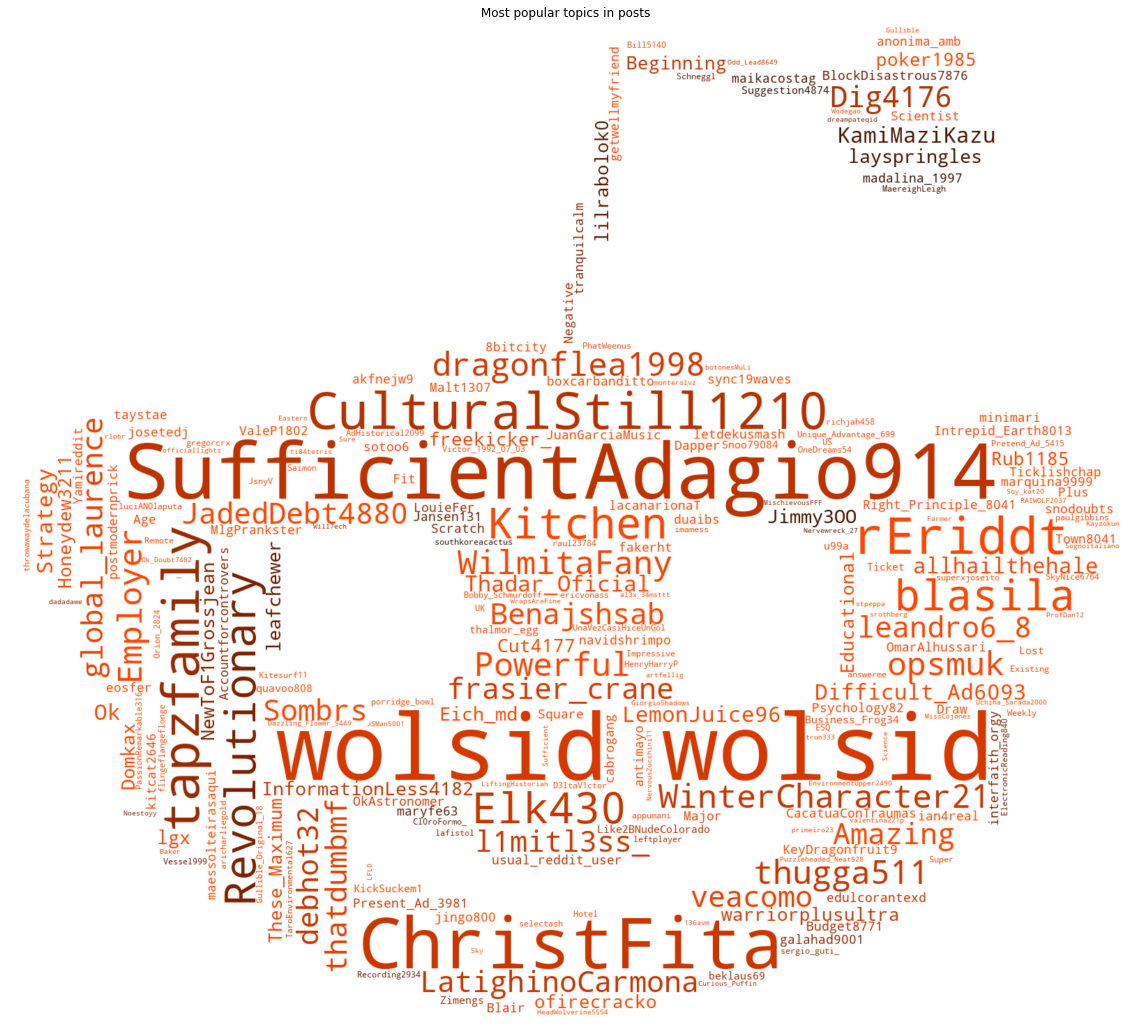

In [ ]:
text = " ".join([i for i in kdf.author.to_numpy()])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular topics in posts")
plt.axis("off");

In [ ]:
text = " ".join([i for i in kdf.title.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular topics in title")
plt.axis("off");

KeyboardInterrupt: ignored

In [ ]:
text = " ".join([i for i in kdf.subreddit.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular subreddits")
plt.axis("off");

--------


<font size=10 color=red>Assignment question</font>
--------
Choose a subreddit you like and build a worldcloud using Koalas. Feel free to change the mask or the colors...
--------
--------
Answer: 

Below there is the code to generate our wordcloud of the using Koalas

In [ ]:
!curl https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Real_Betis.svg/2500px-Real_Betis.svg.png > betis.png

In [ ]:
!curl https://i.pinimg.com/originals/0f/cc/9f/0fcc9f39706323df3bf19cacc621a02d.jpg > betis.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58291  100 58291    0     0   218k      0 --:--:-- --:--:-- --:--:--  218k


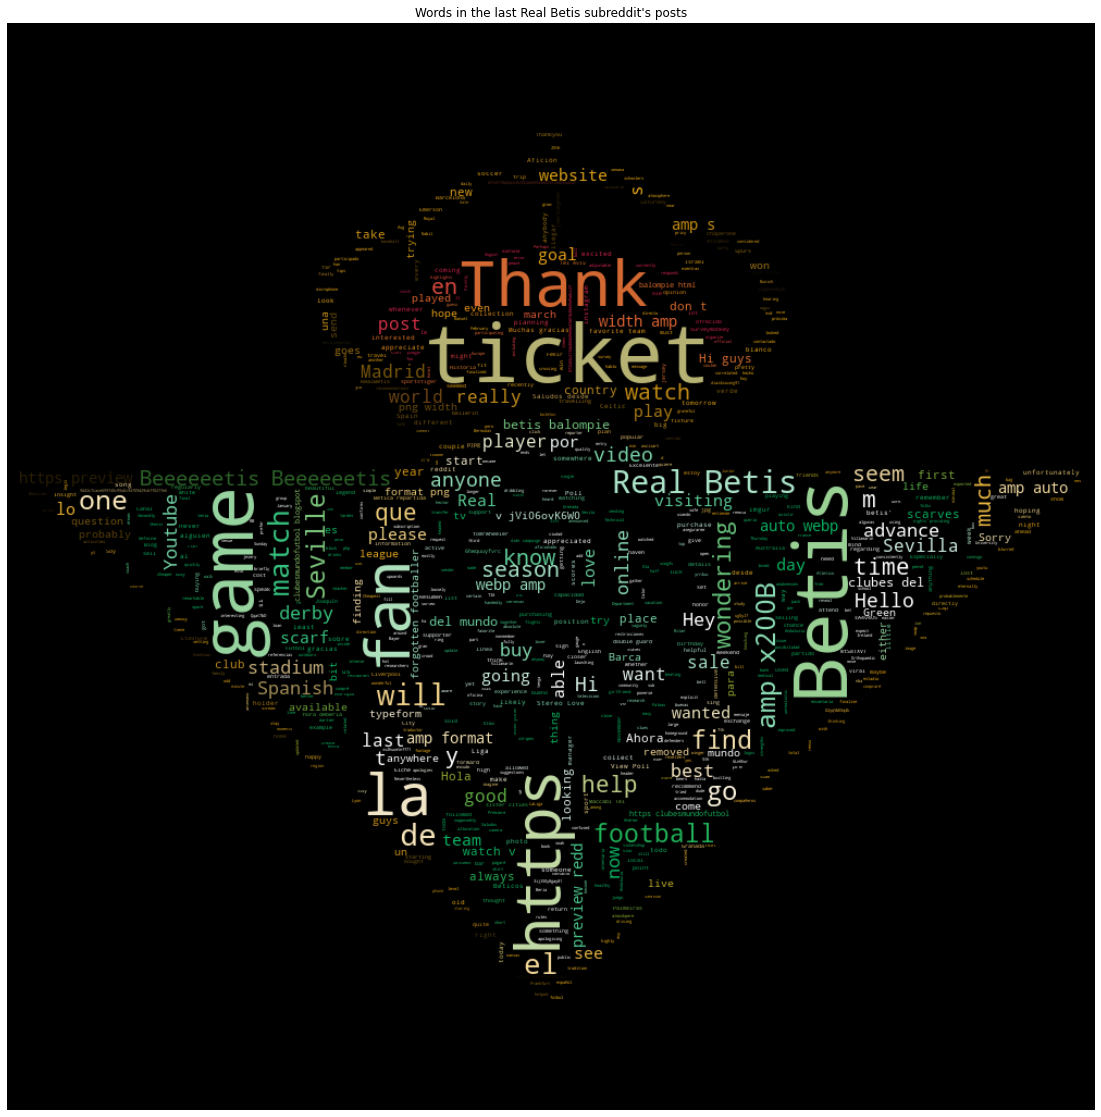

In [ ]:
pdf = loadRedditToPandas("RealBetis")
mask = np.array(Image.open("betis.png"))
text = " ".join([i for i in pdf.selftext.to_numpy()])
wordcloud = WordCloud(max_words=10000, mask=~mask[:,:,0], background_color="black", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Words in the last Real Betis subreddit's posts")
plt.axis("off");

--------


<font size=10 color=red>Assignment question</font>
--------
Is the current implementation of the word cloud using Spark to speed up the computations? Why?/Why not? Implement an improved version.
--------
--------
Answer:

No, the current implementation is not using spark to speed up the computations because it is not parallelizing. In order to speed up the computations the code would be the following:
First we generate a flatmap that contains all the words of the posts gathered with the reddit api (with more than 4 characters to avoid articles and avoiding punctuation signs). After that we make a key value map and finally we reduce by key and add  the frequency values. 
After all this when we call the Wordcloud function with generate_from _frequencies we pass the ffreq argument only now with the collectAsMap function.


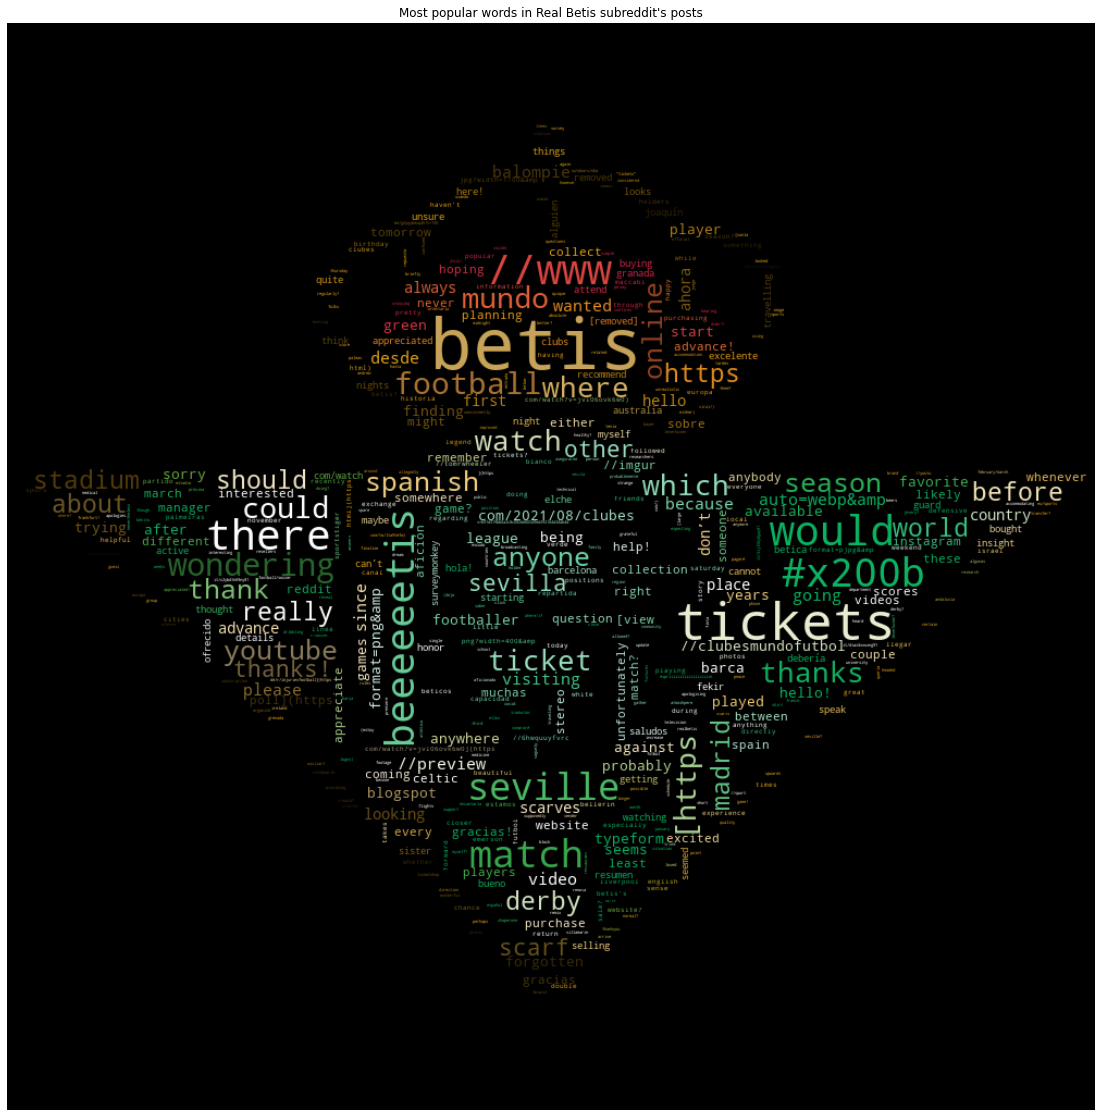

In [ ]:
pdf = loadRedditToPandas("RealBetis")
mask = np.array(Image.open("betis.png"))
text =  sc.parallelize(pdf.selftext)
allWords = text.flatMap(lambda w: re.sub(""";|:|\.|,|-|–|"|'|\s"""," ", w.lower()).split(" ")).filter(lambda a: len(a)>4)
freq = allWords.map(lambda a: (a, 1))
ffreq = freq.reduceByKey(lambda a,b: a+b)

wordcloud = WordCloud(max_words=10000, mask=~mask[:,:, 0], background_color="black", mode="RGBA").generate_from_frequencies(ffreq.collectAsMap())
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular words in Real Betis subreddit's posts")
plt.axis("off");
